In [1]:
from PIL import Image
from numpy import asarray
import pickle
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import glob
import os
import cv2
import tensorflow as tf
from tensorflow import keras
import sys
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from google.colab import drive
from datetime import datetime, timedelta
drive.mount('/content/drive')
np.random.seed(7)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#train1 labeling 및 전처리
text = "root1_220823174615.jpg"
n = 7
result = text[6:n+11]
date_time = datetime.strptime(result, "%y%m%d%H%M%S")
formatted_date_time = date_time.strftime("%Y년 %m월 %d일 %H시 %M분 %S초")

output_list = []

for _ in range(6):
    delta = timedelta(minutes=720)

    # 시간 증가
    new_date_time = date_time + delta

    # 증가된 시간 출력
    formatted_date_time = new_date_time.strftime("%Y년 %m월 %d일 %H시 %M분 %S초")

    date_time = datetime.strptime(formatted_date_time, "%Y년 %m월 %d일 %H시 %M분 %S초")
    formatted_number = date_time.strftime("%y%m%d%H%M%S")

    output_list.append(int(formatted_number))

image_directory = "/content/drive/MyDrive/root1_220823"

x_train = []
y_train = []

# Iterate over the files in the directory
for filename in os.listdir(image_directory):
    # Read the image
    image = cv2.imread(os.path.join(image_directory, filename))
    
    # Check if image is not empty
    if image is not None:
        # Resize the image to match the MNIST dataset size (32x32 pixels)
        try:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_image  = gray_image[:, 80:-60] 
            gray_image = cv2.resize(gray_image, (32, 32))
 
            x_train.append(gray_image)
            text = filename
            n = 7
            result = text[6: n + 11]
            y_train.append(result)
        except Exception as e:
            print(f"Error processing image {filename}: {str(e)}")

# Convert the training data to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

x_train=x_train.astype('float32')/255.0
x_train = x_train.reshape(x_train.shape[0], 32, 32, 1) #1채널 형태로 바꿔야함(data processing에서 중요)
input_shape = (32,32,1)

Tmp=output_list

# Determine the class for each label
y_train_classes = []
for label in y_train:
    label=int(label)
    if label < Tmp[0]:
        class_index = 0
    elif Tmp[0] <= label < Tmp[1]:
        class_index = 1
    elif Tmp[1] <= label < Tmp[2]:
        class_index = 2
    elif Tmp[2] <= label < Tmp[3]:
        class_index = 3
    elif Tmp[3] <= label < Tmp[4]:
        class_index = 4
    elif Tmp[4] <= label < Tmp[5]:
        class_index = 5
    else:
        class_index = 6
    y_train_classes.append(class_index)

# Convert the class labels to one-hot encoded vectors
num_classes = len(Tmp) + 1
y_train_one_hot = keras.utils.to_categorical(y_train_classes, num_classes)

In [3]:
#train2 labeling 및 전처리
text = "root1_221121150621.jpg"
n = 7
result = text[6:n+11]
date_time = datetime.strptime(result, "%y%m%d%H%M%S")
formatted_date_time = date_time.strftime("%Y년 %m월 %d일 %H시 %M분 %S초")

output_list = []

for _ in range(6):
    delta = timedelta(minutes=720)

    # 시간 증가
    new_date_time = date_time + delta

    # 증가된 시간 출력
    formatted_date_time = new_date_time.strftime("%Y년 %m월 %d일 %H시 %M분 %S초")

    date_time = datetime.strptime(formatted_date_time, "%Y년 %m월 %d일 %H시 %M분 %S초")
    formatted_number = date_time.strftime("%y%m%d%H%M%S")

    output_list.append(int(formatted_number))

image_directory = "/content/drive/MyDrive/root1_221121_훌륭"

x_train1 = []
y_train = []

# Iterate over the files in the directory
for filename in os.listdir(image_directory):
    # Read the image
    image = cv2.imread(os.path.join(image_directory, filename))
    
    # Check if image is not empty
    if image is not None:
        # Resize the image to match the MNIST dataset size (32x32 pixels)
        try:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_image  = gray_image[:, 80:-60] 
            gray_image = cv2.resize(gray_image, (32, 32))
 
            x_train1.append(gray_image)
            text = filename
            n = 7
            result = text[6: n + 11]
            y_train.append(result)
        except Exception as e:
            print(f"Error processing image {filename}: {str(e)}")

# Convert the training data to numpy arrays
x_train1 = np.array(x_train1)
y_train = np.array(y_train)

x_train1=x_train1.astype('float32')/255.0
x_train1 = x_train1.reshape(x_train1.shape[0], 32, 32, 1) #1채널 형태로 바꿔야함(data processing에서 중요)
input_shape = (32,32,1)

#train 데이터 catergorical labeling을 위해 one-hot encoding
t1_tmp=output_list

# Determine the class for each label
y_train_classes = []
for label in y_train:
    label=int(label)
    if label < t1_tmp[0]:
        class_index = 0
    elif t1_tmp[0] <= label < t1_tmp[1]:
        class_index = 1
    elif t1_tmp[1] <= label < t1_tmp[2]:
        class_index = 2
    elif t1_tmp[2] <= label < t1_tmp[3]:
        class_index = 3
    elif t1_tmp[3] <= label < t1_tmp[4]:
        class_index = 4
    elif t1_tmp[4] <= label < t1_tmp[5]:
        class_index = 5
    else:
        class_index = 6
    y_train_classes.append(class_index)

# Convert the class labels to one-hot encoded vectors
num_classes = len(t1_tmp) + 1
y_train1_one_hot = keras.utils.to_categorical(y_train_classes, num_classes)

In [4]:
#test labeling 및 전처리
text = "root1_220923114836.jpg"

n = 7
result = text[6:n+11]
date_time = datetime.strptime(result, "%y%m%d%H%M%S")
formatted_date_time = date_time.strftime("%Y년 %m월 %d일 %H시 %M분 %S초")

test_output_list = []

for _ in range(6):
    delta = timedelta(minutes=720)

    # 시간 증가
    new_date_time = date_time + delta

    # 증가된 시간 출력
    formatted_date_time = new_date_time.strftime("%Y년 %m월 %d일 %H시 %M분 %S초")

    date_time = datetime.strptime(formatted_date_time, "%Y년 %m월 %d일 %H시 %M분 %S초")
    formatted_number = date_time.strftime("%y%m%d%H%M%S")


    test_output_list.append(int(formatted_number))

image_directory = "/content/drive/MyDrive/root1_220923"

x_test = []
y_test = []

# Iterate over the files in the directory
for filename in os.listdir(image_directory):
    # Read the image
    image = cv2.imread(os.path.join(image_directory, filename))
    
    # Check if image is not empty
    if image is not None:
        # Resize the image to match the MNIST dataset size (32x32 pixels)
        try:
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_image  = gray_image[:, 80:-60] 
            gray_image = cv2.resize(gray_image, (32, 32))
            x_test.append(gray_image)
            text = filename
            n = 7
            result = text[6: n + 11]
            y_test.append(result)
        except Exception as e:
            print(f"Error processing image {filename}: {str(e)}")

# Convert the testing data to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

x_test = x_test.astype('float32')/255.0
x_test = x_test.reshape(x_test.shape[0], 32, 32, 1) #1채널 형태로 바꿔야함(data processing에서 중요)
input_shape = (32,32,1)

test_tmp= test_output_list

# Determine the class for each label
y_test_classes = []

for label in y_test:
    label=int(label)
    if label < test_tmp[0]:
        class_index = 0
    elif test_tmp[0] <= label < test_tmp[1]:
        class_index = 1
    elif test_tmp[1] <= label < test_tmp[2]:
        class_index = 2
    elif test_tmp[2] <= label < test_tmp[3]:
        class_index = 3
    elif test_tmp[3] <= label < test_tmp[4]:
        class_index = 4
    elif test_tmp[4] <= label < test_tmp[5]:
        class_index = 5
    else:
        class_index = 6        
    y_test_classes.append(class_index)

# Convert the class labels to one-hot encoded vectors
num_classes = len(test_tmp) + 1
y_test_one_hot = keras.utils.to_categorical(y_test_classes, num_classes)

In [5]:
#cnn model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape)) #64 channels
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2))) #특징들의 확률을 확실히 decision
model.add(Dropout(0.25))  #트레인 튜런중 일부를 꺼서 오버피팅 막음

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) #각 레이어를 통해 추출된 특징들을 2차원에서 1차원으로 바꿔 fully connected layer에 들어가기 전 바꾼다
model.add(Dense(2048, activation='relu', kernel_regularizer=l2(0.001))) #입력받는 노드들과 출력으로 나가는 노드들의 개수를 받아 연결한다
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [6]:
#train 데이터를 fitting
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
batch_size = 16
epochs = 30

train_accs = []
train_losses = []
test_accs = []
test_losses = []

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
x_combined = np.concatenate((x_train, x_train1), axis=0)
y_combined = np.concatenate((y_train_one_hot, y_train1_one_hot), axis=0)

hist=model.fit(x_combined, y_combined, batch_size=batch_size, validation_data=(x_test, y_test_one_hot), callbacks=[reduce_lr], epochs=epochs)

Epoch 1/30
67/67 [==============================] - 16s 29ms/step - loss: 6.3153 - accuracy: 0.6058 - val_loss: 8.9754 - val_accuracy: 0.0719 - lr: 0.0010
Epoch 2/30
67/67 [==============================] - 1s 14ms/step - loss: 4.8011 - accuracy: 0.6573 - val_loss: 7.3229 - val_accuracy: 0.0719 - lr: 0.0010
Epoch 3/30
67/67 [==============================] - 1s 17ms/step - loss: 4.3955 - accuracy: 0.6760 - val_loss: 6.5159 - val_accuracy: 0.0719 - lr: 0.0010
Epoch 4/30
67/67 [==============================] - 1s 14ms/step - loss: 3.7783 - accuracy: 0.7228 - val_loss: 7.5099 - val_accuracy: 0.0719 - lr: 0.0010
Epoch 5/30
67/67 [==============================] - 1s 13ms/step - loss: 3.4073 - accuracy: 0.7294 - val_loss: 8.4025 - val_accuracy: 0.0719 - lr: 0.0010
Epoch 6/30
66/67 [============================>.] - ETA: 0s - loss: 3.0493 - accuracy: 0.7576
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
67/67 [==============================] - 1s 13ms/step - lo

In [7]:
model.evaluate(x_combined, y_combined, batch_size=16)
model.evaluate(x_test,y_test_one_hot, batch_size=16)

32/32 [==============================] - 0s 5ms/step - loss: 3.8229 - accuracy: 0.6148


[3.822948455810547, 0.6147704720497131]

34/34 [==============================] - 1s 4ms/step


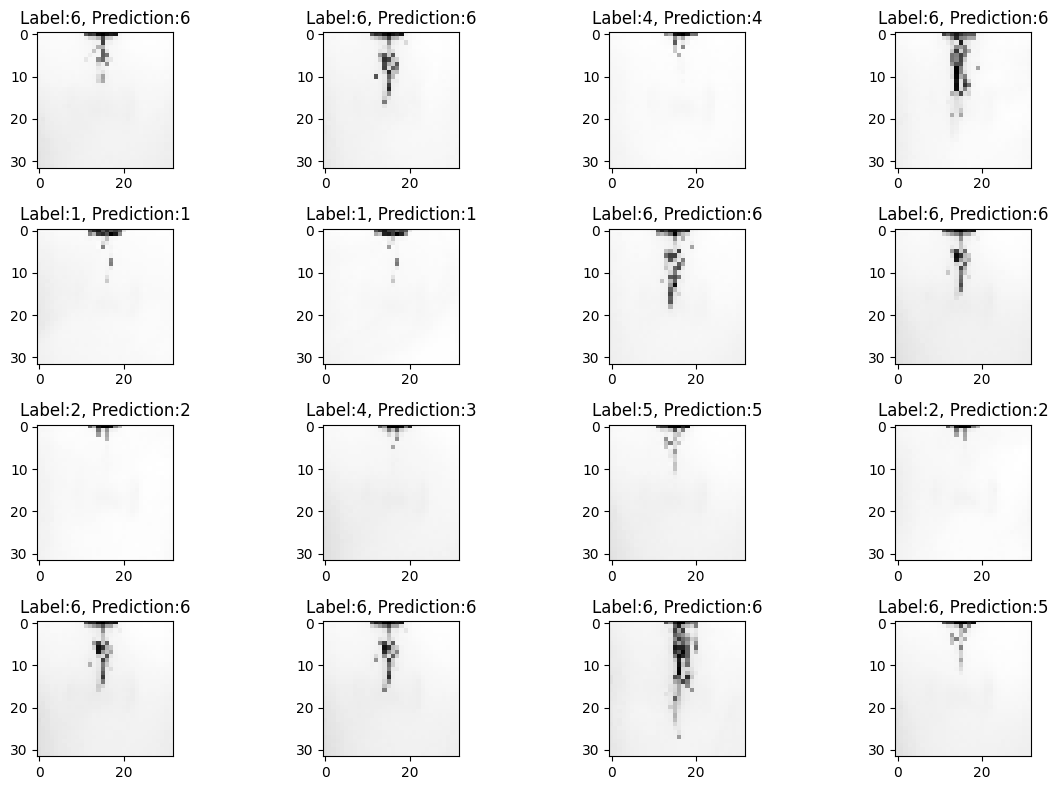

In [8]:
#fitting된 모델로 train_data 예측 실시
predicted_result = model.predict(x_combined)
predicted_labels = np.argmax(predicted_result, axis=1)

test_labels = np.argmax(y_combined, axis=1)
wrong_result = []

samples = random.sample(range(501), 16)

count = 0
nrows = ncols = 4
plt.figure(figsize=(12,8))

for n in samples:
    count += 1
    plt.subplot(nrows, ncols, count)
    plt.imshow(x_combined[n], cmap='Greys', interpolation='nearest')
    tmp = "Label:" + str(test_labels[n]) + ", Prediction:" + str(predicted_labels[n])
    plt.title(tmp)

plt.tight_layout()
plt.show()

16/16 [==============================] - 0s 19ms/step


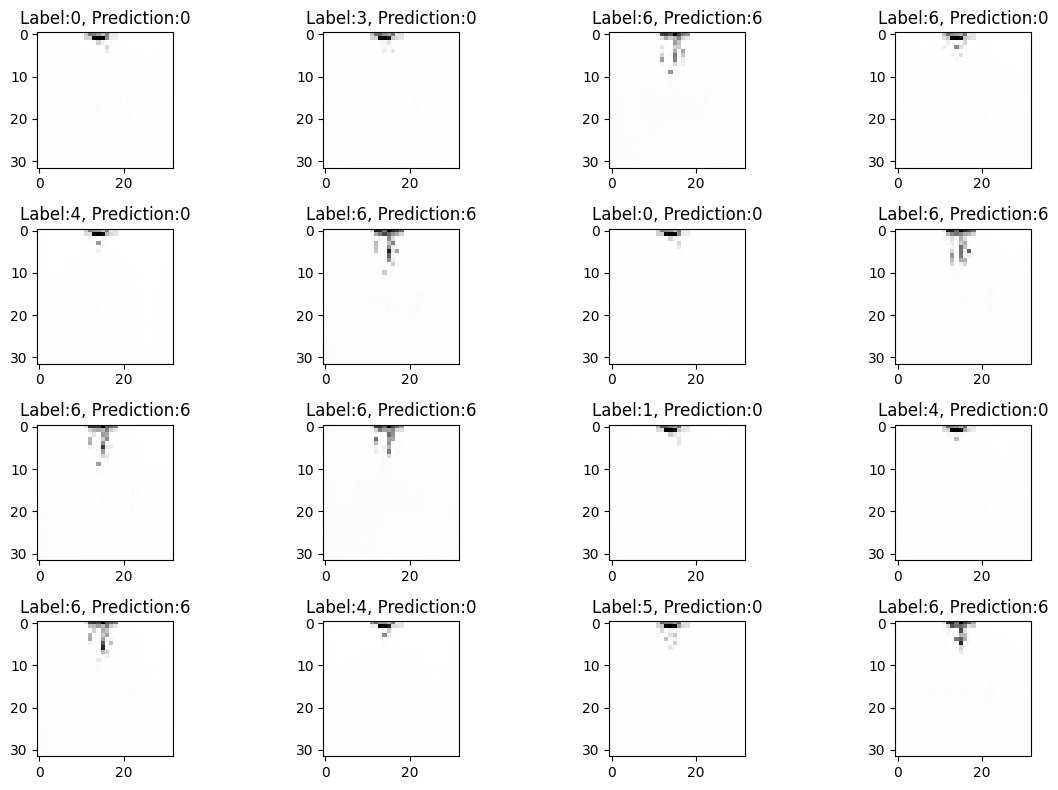

In [9]:
#fitting된 모델로 test_data 예측 실시
predicted_result = model.predict(x_test)
predicted_labels = np.argmax(predicted_result, axis=1)

test_labels = np.argmax(y_test_one_hot, axis=1)
wrong_result = []

random_numbers = random.sample(range(501), 16)
  
count = 0
nrows = ncols = 4
plt.figure(figsize=(12,8))

for n in random_numbers:
    count += 1
    plt.subplot(nrows, ncols, count)
    plt.imshow(x_test[n], cmap='Greys', interpolation='nearest')
    tmp = "Label:" + str(test_labels[n]) + ", Prediction:" + str(predicted_labels[n])
    plt.title(tmp)

plt.tight_layout()
plt.show()

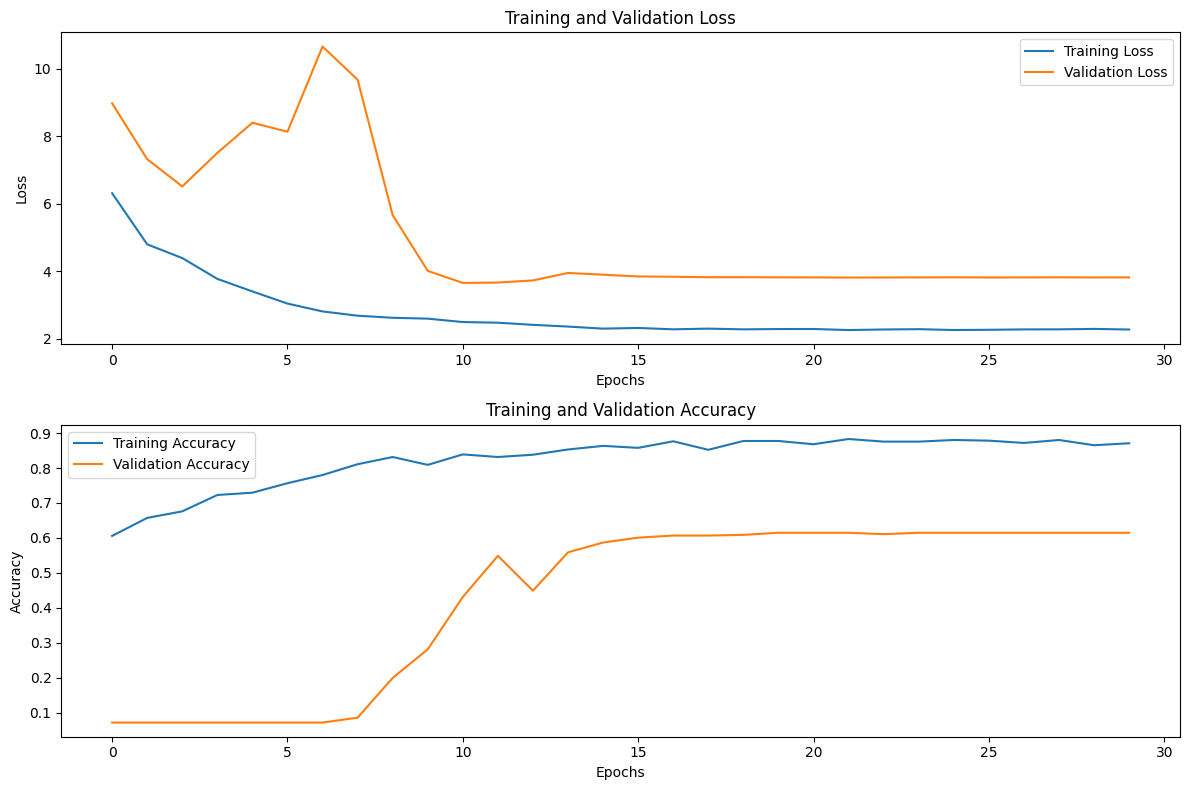

In [10]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()  # Adjust spacing between subplots
plt.show()